In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])
torch.Size([600, 2]) torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([600]) torch.Size([200]) torch.Size([200])


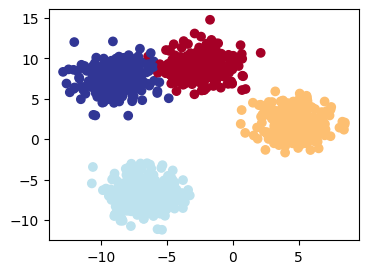

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5,
    random_state=RANDOM_SEED
)
X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X[:5], y[:5])

X_trainval, X_test, y_trainval, y_test =train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val =train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

plt.figure(figsize=(4,3))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [4]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [5]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

/home/dorota/projects/Deep-Machine-Learning-Dorota-Bjoorn/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_4(X_train) # tensor [600, 4]
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # [600]; logits -> prediction probabilities -> prediction labels
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
      val_logits = model_4(X_val)
      val_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)
      val_loss = loss_fn(val_logits, y_val)
      val_acc = accuracy_fn(y_true=y_val,
                             y_pred=val_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Val Loss: {val_loss:.5f}, Val Accuracy: {val_acc:.2f}%")

Epoch: 0 | Loss: 3.26313, Accuracy: 1.17% | Val Loss: 0.92084, Val Accuracy: 55.00%
Epoch: 10 | Loss: 0.21510, Accuracy: 96.67% | Val Loss: 0.21657, Val Accuracy: 96.00%
Epoch: 20 | Loss: 0.09719, Accuracy: 99.17% | Val Loss: 0.11167, Val Accuracy: 98.00%
Epoch: 30 | Loss: 0.06575, Accuracy: 99.17% | Val Loss: 0.08326, Val Accuracy: 98.00%
Epoch: 40 | Loss: 0.05150, Accuracy: 99.17% | Val Loss: 0.07036, Val Accuracy: 98.00%
Epoch: 50 | Loss: 0.04353, Accuracy: 99.17% | Val Loss: 0.06329, Val Accuracy: 98.00%
Epoch: 60 | Loss: 0.03848, Accuracy: 99.17% | Val Loss: 0.05895, Val Accuracy: 98.00%
Epoch: 70 | Loss: 0.03502, Accuracy: 99.17% | Val Loss: 0.05609, Val Accuracy: 98.50%
Epoch: 80 | Loss: 0.03250, Accuracy: 99.17% | Val Loss: 0.05412, Val Accuracy: 98.50%
Epoch: 90 | Loss: 0.03060, Accuracy: 99.17% | Val Loss: 0.05269, Val Accuracy: 98.50%


In [9]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    test_logits = model_4(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1) 
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

print(test_pred.shape, y_test.shape)
print(test_loss.item(), test_acc)

torch.Size([200]) torch.Size([200])
0.02748171053826809 99.5


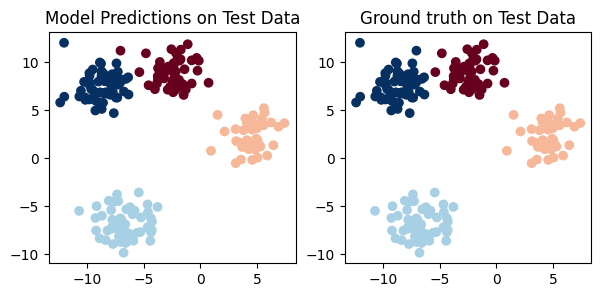

In [10]:
plt.figure(figsize=(7,3))

plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_pred, cmap=plt.cm.RdBu)
plt.title('Model Predictions on Test Data')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu)
plt.title('Ground truth on Test Data');